## Multinomial Naive Bayes

The Naive Bayes classification algorithm is a classification modeling technique that relies on Bayes Theorem and assumes that every feature it models on is independent of one another. This assumption makes it easier to calculate probabilities. I chose Multinomial Naive Bayes, as it is used for classification with discrete features.  It predicts each comments' probability of being part of KOFT or MSOG by using the probability that each of its features is part of KOFT or MSOG. 

Source: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [5]:
import numpy as np
import requests, time, csv, json, re  
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.naive_bayes import MultinomialNB
import nltk

This imports the libraries we need. 

In [4]:
Complete_df = pd.read_json('../data/Complete_dataframe.json')

This reads in the Complete_df that we generated earlier

In [13]:
X_train, X_test, y_train, y_test = train_test_split(Complete_df['body'],
                                                    Complete_df['KOFT'],
                                                    test_size = 0.25,
                                                    random_state = 42)

This generates a train test split of my Complete_df. 

In [14]:
nb = MultinomialNB()

This instantiates my Multinomial Naive Bayes model. 

In [15]:
stopwords = nltk.corpus.stopwords.words('english')

This sets the default stopwords to be used in text analysis to the nltk corpus' English stopwords. 

In [16]:
extrastopwords=['deck','decks','card','cards','meta','https','good','playing','better','ladder','dust','legendary','rank',
                'board','game','win','play','like','1x','2x','bad','think','would','much','list','one','really','get','turn'
               'legend','mana','every','actually','many']

This initializes a list of additional stopwords to be added. 

In [17]:
stopwords.extend(extrastopwords)

This adds the list of additional stopwords. 

In [18]:
pipe_tfidf_nb = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('nb', MultinomialNB())
])

In [19]:
pipe_params_tfidf_nb = {
    'tfidf__max_features': [2500, 3000, 3500],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.9, .95],
    'tfidf__ngram_range': [(1,1), (1,2)]
}
gs_tfidf_nb = GridSearchCV(pipe_tfidf_nb, param_grid=pipe_params_tfidf_nb, cv=3)
gs_tfidf_nb.fit(X_train, y_train)
print(gs_tfidf_nb.best_score_)
gs_tfidf_nb.best_params_

0.7892462453952961


{'tfidf__max_df': 0.9,
 'tfidf__max_features': 3500,
 'tfidf__min_df': 2,
 'tfidf__ngram_range': (1, 2)}

GridSearchCV splits my data up into three separate splits, and then uses 2 of the three splits as training data and the last split as testing data, and switches between each of the three splits as the test split when running models using each combination of the above parameters.  The cvec__max_features sets the maximum amount of features CountVectorizer is allowed to use to 3500. The parameter cvec__min_df ignores all terms that only appear in under 3 documents. The parameter cvec__max_df ignores all terms that appear above 90 percent of the time. The parameter cvec__ngram_range sets the range of acceptable n_grams to (1,2). TfidfVectorizer is then run with the above optimal parameters. 

In [20]:
gs_tfidf_nb.score(X_train,y_train)

0.8360017001983565

In [45]:
gs_tfidf_nb.score(X_test,y_test)

0.7936676583085422

Since my training score is slightly higher than my test score, I believe that my model might be slightly overfit. 

In [22]:
coef = list(gs_tfidf_nb.best_estimator_.named_steps['nb'].coef_[0])

In [23]:
list_of_features_df = pd.DataFrame(data=gs_tfidf_nb.best_estimator_.named_steps['tfidf'].get_feature_names(), columns=['Feature'])

In [24]:
coef_df = pd.DataFrame(data=coef, columns=['coef'])

In [25]:
combined_df = pd.DataFrame(data = [list_of_features_df['Feature'],coef_df['coef']])

In [26]:
combined_df = combined_df.T

In [27]:
combined_df.set_index('Feature',drop=True,inplace=True)

In [28]:
combined_df.head()

,coef
Feature,
00,-10.1192
10,-6.56188
10 10,-9.05304
10 games,-8.66683
100,-7.55074


The above code generates a DataFrame with the list of features as the index and their corresponding coefs. 

Text(0, 0.5, 'Feature')

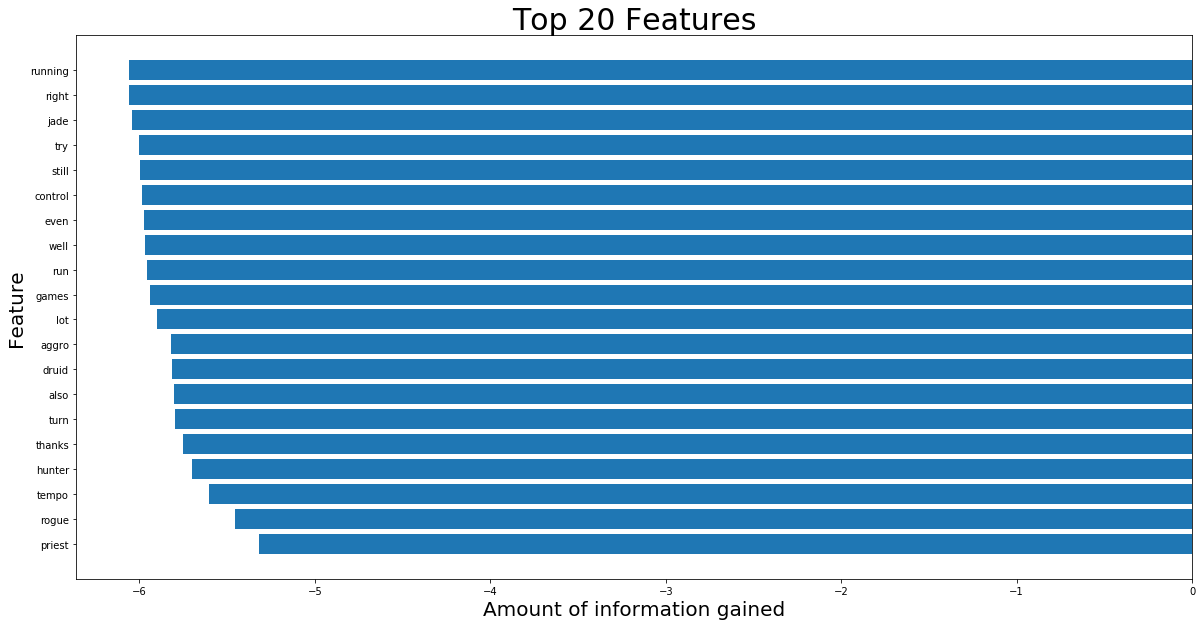

In [41]:
plt.figure(figsize=(20,10))
temp = combined_df.sort_values('coef', ascending=False).head(20)
plt.barh(temp.index, temp['coef'])
plt.title('Top 20 Features', fontsize=30)
plt.xlabel('Amount of information gained', fontsize=20)
plt.ylabel('Feature', fontsize=20)

The top 20 features all appear to give me a negative amount of information. Thus, I believe that this model gives me a null result. 

In [30]:
predictions = gs_tfidf_nb.predict_proba(X_test)

In [31]:
print(roc_auc_score(y_test, predictions[:,1]))

0.8884191123345472


The roc_auc_score is evaluated on a scale of 0.5 to 1. Since my roc_auc_score is 0.8884191123345472 in this case, I believe that it is sufficient. 

Text(0.5, 1.0, 'Multinomial NB ROC curve')

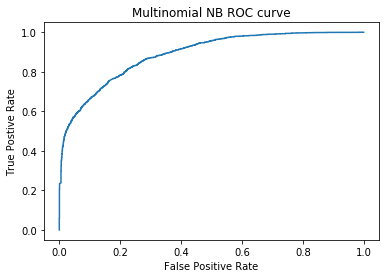

In [43]:
predictions = gs_tfidf_nb.predict_proba(X_test)
false_positive_rate,true_positive_rate, thresholds= roc_curve(y_test, predictions[:,1])
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('False Positive Rate')
plt.ylabel('True Postive Rate')
plt.title('Multinomial NB ROC curve')

This plots the ROC curve of my Multinomial Naive Bayes Model. 